In [1]:
import os,subprocess
workdir='/nagyvinyok/adat84/sotejedlik/ribli/expression/prepare_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot')
%matplotlib inline

### Filename tcga barcode mappings

In [2]:
fs_map=pd.read_csv('../data/brca_rnaseq/FILE_SAMPLE_MAP.txt',sep='\t')
#fs_map=fs_map.iloc[:-1,:]
fs_dict={}
for i in xrange(len(fs_map)):
    fs_dict[fs_map.iloc[i,0]]=fs_map.iloc[i,1]
    
    
tum_dict={}
for i in xrange(len(fs_map)):
    if ( fs_map.iloc[i,1].split('-')[3][0]=='0'):
        tum_dict[fs_map.iloc[i,0]]='tumor'
    else:
        tum_dict[fs_map.iloc[i,0]]='normal'

### Load all normal data

In [3]:
datadir='../data/brca_rnaseq/RNASeqV2/UNC__IlluminaHiSeq_RNASeqV2/Level_3/'

In [4]:
import gc
import os
from glob import glob
df_list,tum_list,norm_list=[],[],[]
gene_df=pd.DataFrame()
i=0
for filename in glob(datadir+'*junction_quantification.txt'):
    fname=os.path.basename(filename)
    
    #df_list.append(tmp_df[['RPKM']])
    if tum_dict[fname]=='tumor':
        'nothing'
        #tum_list.append(tmp_df[['RPKM']])
    else:
        tmp_df=pd.read_csv(filename, sep='\t',header=0)
        gene_df=tmp_df.junction
        norm_list.append(tmp_df[['raw_counts']])
        
    print '.',
    i+=1
    if i%100==0:
        print i,
    gc.collect()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 100 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 200 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 300 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 400 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

### Create Psi data

In [5]:
n_data_matrix=pd.concat([gene_df]+norm_list,axis=1)
data=pd.concat([gene_df]+[n_data_matrix.drop('junction',axis=1).sum(axis=1)],axis=1)

n_data_matrix=0
norm_list = 0
gc.collect()

data['chr1']=[x.split(',')[0].split(':')[0] for x in data.junction]
data['chr2']=[x.split(',')[1].split(':')[0] for x in data.junction]

data['pos1']=[int(x.split(',')[0].split(':')[1]) for x in data.junction]
data['pos2']=[int(x.split(',')[1].split(':')[1]) for x in data.junction]

data['strand1']=[x.split(',')[0].split(':')[2] for x in data.junction]
data['strand2']=[x.split(',')[1].split(':')[2] for x in data.junction]


data=data[data.chr1==data.chr2]
data['chr']=data.chr1
data.drop(['chr1','chr2'],axis=1,inplace=True)

data=data[data.strand1==data.strand2]
data['strand']=data.strand1
data.drop(['strand1','strand2'],axis=1,inplace=True)

data.drop('junction',axis=1,inplace=True)

data.head()

,0,pos1,pos2,chr,strand
0,0,12227,12595,chr1,+
1,3,12227,12613,chr1,+
2,0,12227,12646,chr1,+
3,2,12697,13221,chr1,+
4,0,12721,13221,chr1,+


In [6]:
jctrip=pd.concat([data[:-2],data[1:-1].reset_index(drop=True),data[2:].reset_index(drop=True)],axis=1,ignore_index=True)

cass=jctrip[ (jctrip[1]==jctrip[6]) & (jctrip[7]==jctrip[12]) ].reset_index(drop=True)

cass.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,6463,14829,14970,chr1,-,40,14829,15796,chr1,-,1693,15038,15796,chr1,-
1,0,17055,17259,chr1,-,1745,17055,17606,chr1,-,12855,17368,17606,chr1,-
2,12855,17368,17606,chr1,-,30,17368,17915,chr1,-,13253,17742,17915,chr1,-
3,3579,787490,788051,chr1,+,469,787490,788771,chr1,+,5062,788146,788771,chr1,+
4,397,908390,908566,chr1,+,8,908390,908880,chr1,+,265,908706,908880,chr1,+


In [7]:
#mapping control
cass_filt=cass[cass[0]+cass[5]+cass[10] > 20]

n_inc= cass_filt[0]+cass_filt[10]
n_exc= cass_filt[5]
psi=0.5* n_inc /(0.5 * n_inc + n_exc)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1289: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


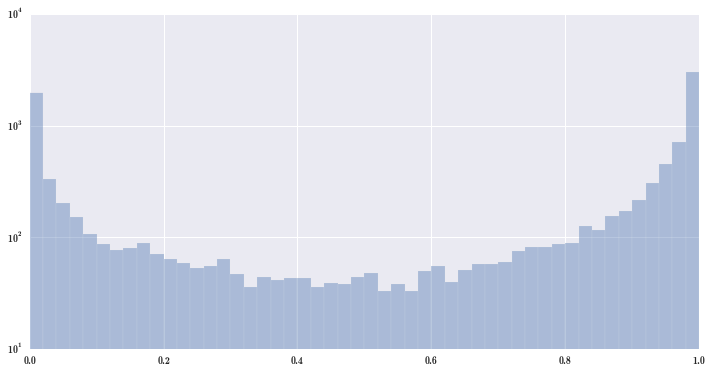

In [8]:
import seaborn as sns
plt.figure(figsize=(12,6))
dump=sns.distplot(psi,bins=50,kde=False)
plt.yscale('log')

In [9]:
cass_filt.loc[:,'psi']=psi.values
cass_filt.head()

/home/ribli/.local/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ribli/.local/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,psi
0,6463,14829,14970,chr1,-,40,14829,15796,chr1,-,1693,15038,15796,chr1,-,0.990287
1,0,17055,17259,chr1,-,1745,17055,17606,chr1,-,12855,17368,17606,chr1,-,0.786479
2,12855,17368,17606,chr1,-,30,17368,17915,chr1,-,13253,17742,17915,chr1,-,0.997707
3,3579,787490,788051,chr1,+,469,787490,788771,chr1,+,5062,788146,788771,chr1,+,0.902077
4,397,908390,908566,chr1,+,8,908390,908880,chr1,+,265,908706,908880,chr1,+,0.976401


### sanity check

In [10]:
# same chroms
assert 0==len(cass_filt[ (cass_filt[3]!=cass_filt[8]) |  (cass_filt[8]!=cass_filt[13])])

#same strands
assert 0==len(cass_filt[ (cass_filt[4]!=cass_filt[9]) |  (cass_filt[9]!=cass_filt[14])])

In [11]:
prep_data=cass_filt[[3,4,1,2,11,7,'psi']]
prep_data.columns=['chr','strand','pos1','pos2','pos3','pos4','psi']
prep_data.head()

,chr,strand,pos1,pos2,pos3,pos4,psi
0,chr1,-,14829,14970,15038,15796,0.990287
1,chr1,-,17055,17259,17368,17606,0.786479
2,chr1,-,17368,17606,17742,17915,0.997707
3,chr1,+,787490,788051,788146,788771,0.902077
4,chr1,+,908390,908566,908706,908880,0.976401


## Create naive feature vectors

In [12]:
from bx.bbi.bigwig_file import BigWigFile
datadir='/nagyvinyok/adat84/sotejedlik/ribli/expression/data/encode/'
bw = BigWigFile( open( datadir+'hg38.phyloP100way.bw') )

In [15]:
def exon_to_csv(input_df,output_fname,txn_data,plus=100,minus=100):
    """
    Create relatively small csv files from pandas df of probes.
    
    Used in naive prediction as feauture vectors.
    """

    with open(output_fname,'w') as out_f:
        for i in xrange(len(input_df)):
            out_f.write(make_naive_line(input_df.iloc[i,:],plus,minus,txn_data))
            
def make_naive_line(line,plus,minus,txn_data):
    """Transform annotation line into naive feature vector line."""
    chrom,strand,pos1,pos2,pos3,pos4,psi=line
    
     #seq depending on strand
    if strand=='+':
        out_line = '\t'.join(map(str,np.concatenate([
                        getcons(chrom,pos1-minus,pos1+plus,bw),
                        getcons(chrom,pos2-minus,pos2+plus,bw),
                        getcons(chrom,pos3-minus,pos3+plus,bw),
                        getcons(chrom,pos4-minus,pos4+plus,bw)])))
    elif strand=='-':
        out_line = '\t'.join(map(str,np.concatenate([
                        getcons(chrom,pos4-plus,pos4+minus,bw)[::-1],
                        getcons(chrom,pos3-plus,pos3+minus,bw)[::-1],
                        getcons(chrom,pos2-plus,pos2+minus,bw)[::-1],
                        getcons(chrom,pos1-plus,pos1+minus,bw)[::-1]])))
    
    out_line+='\t'+str(psi)+'\n'
    return out_line
                
def getcons(chrom,pos1,pos2,bwfile):
    x=np.arange(pos1,pos2)
    res=np.array([ np.nan_to_num(y['mean']) for y in bw.query(chrom,pos1,pos2,pos2-pos1) ])
    return x,res

In [ ]:
start=time.time()
out_fname='cons_feat_vect_200.csv'
exon_to_csv(prep_data,output_fname=out_fname,txn_data=data,plus=200,minus=200)
print 'it took :',time.time()-start,'s'